## Условная оптимизация

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from IPython import display
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
import cvxopt
from cvxopt import solvers

In [2]:
matplotlib.rcParams['figure.figsize']=(8, 8)
sns.set_style('whitegrid')

$(1) \ \left \{ \begin{array}{l} f_{0}(x) \to \min\limits_{x} \\ g_{i}(x) \le 0, \ i = 1, \dots, m \\ h_{j}(x) = 0, \ j = 1, \dots, k  \end{array}   \right .$

Лагранжиан: $L(x, \lambda, \mu) = f_{0}(x) + \sum\limits_{i=1}^m \lambda_{i} \cdot g_{i}(x) + \sum\limits_{j=1}^k \mu_{j} \cdot h_{j}(x)$

${\bf \text{Необходимое условие (Условия Каруша-Куна-Таккера):}} \ Пусть \ \exists x^{\ast}$, такой что в нём выполнены "условия регулярности". Тогда если $x^{\ast}$ - точка локального минимума для задачи (1), то $\exists \lambda^{\ast}, \ \mu^{\ast}:$ 

1) Стационарность:

$\nabla_{x} L(x^{\ast}, \lambda^{\ast}, \mu^{\ast}) = 0$

2) Дополняющая нежёсткость:

$\lambda^{\ast}_{i} \cdot g_{i}(x^{\ast}) = 0, \ i = 1, \dots, m$ 

$\lambda^{\ast}_{i} \ge 0$

${\bf \text{Достаточное условие:}}$ Пусть (1) - выпукла (т.е. $f_{0}(x), g_{i}(x)$ - выпуклые функции, $h_{j}(x)$ - афинные функции), тогда если для $(x^{\ast}, \lambda^{\ast}, \mu^{\ast})$ выполнены условия ККТ, то $x^{\ast}$ - точка глобального минимума

${\bf \text{Пример:}}$

$\left\{ \begin{array} { l } { ( x - 4 ) ^ { 2 } + ( y - 4 ) ^ { 2 } \rightarrow \min\limits_{ x , y } } \\ { x + y \leqslant 4 } \\ { x + 3 y \leqslant 9 } \end{array} \right.$

Выпишем Лагранжиан:

$L \left( x , y , \lambda _ { 1 } , \lambda _ { 2 } \right) = ( x - 4 ) ^ { 2 } + ( y - 4 ) ^ { 2 } + \lambda _ { 1 } ( x + y - 4 ) + \lambda _ { 2 } ( x + 3 y - 9 )$

Выпишем Условия ККТ:

$\left\{ \begin{array} { l } { 2 ( x - 4 ) + \lambda _ { 1 } + \lambda _ { 2 } = 0 } \\ { 2 ( y - 4 ) + \lambda _ { 1 } + 3 \lambda _ { 2 } = 0 } \\ { x + y \leqslant 4 , \lambda _ { 1 } \geqslant 0 , \lambda _ { 1 } ( x + y - 4 ) = 0 } \\ { x + 3 y \leqslant 9 , \lambda _ { 2 } \geqslant 0 , \lambda _ { 2 } ( x + 3 y - 9 ) = 0 } \end{array} \right.$

Рассмотрим 4 случая:

1) $x + y = 4 ,\  x + 3 y = 9 , \  \lambda _ { 1 } > 0 , \  \lambda _ { 2 } > 0$

Откуда получаем: $(x, y)$ = (3/2, 5/2) $\Rightarrow$ подставляем в первые два ур-я ККТ и получаем, что $\lambda_{2} = -1 < 0 \Rightarrow$ значит эта точка не является решением

2) $x + y = 4 , \ x + 3 y < 9 , \  \lambda _ { 1 } > 0 , \  \lambda _ { 2 } = 0$

Получаем: $(x, y, \lambda_{1}, \lambda_{2}) = \boxed{(2, 2, 4, 0)} -$ удовлетворяет ККТ

3) $x+y<4, \ x+3y=9, \ \lambda_{1}=0, \ \lambda_{2}>0 $

4) $x+y<4, \ x+3y<9, \ \lambda_{1}=0, \ \lambda_{2}=0 $

Оставшиеся 2 варианта (третий и четвёртый) приводят к противоречию как и 1 вариант (проверьте!)

Ответ: $(x^{\ast}, y^{\ast}) = (2, 2)$

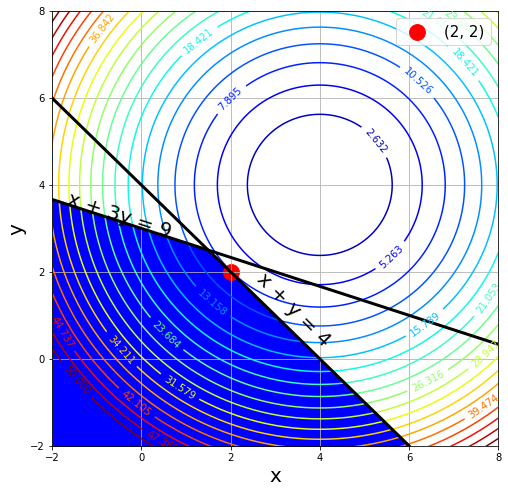

In [64]:
plt.figure(figsize=(8,8))
dom_x = np.linspace(-8, 8, 500)
dom_y = np.linspace(-8, 8, 500)
x_, y_ = np.meshgrid(dom_x, dom_y)
Z = (x_ - 4)**2 + (y_ - 4)**2
V = np.linspace(0, 50, 20)
cs = plt.contour(x_,y_,Z,V,cmap='jet')
plt.plot(dom_x, 4 - dom_x, color='black', linewidth=3)
plt.plot(dom_x, 3 - (1/3)*dom_x, color='black', linewidth=3)
plt.xlim(-2, 8)
plt.ylim(-2, 8)
plt.clabel(cs)
plt.text(-1.7, 2.8, u'x + 3y = 9', fontsize=20, rotation=-18)
plt.text(2.5, 0.3, u'x + y = 4', fontsize=20, rotation=-45)
plt.fill_between(np.linspace(-2, 3/2, 100), 3 - (1/3)*np.linspace(-2, 3/2, 100), y2=-2*np.ones(100), color='blue')
plt.fill_between(np.linspace(3/2, 6, 100), 4 - np.linspace(3/2, 6, 100), y2=-2*np.ones(100), color='blue')
plt.scatter(2, 2, color='red', s=250, label = '(2, 2)')
plt.xlabel(u'x', fontsize=20)
plt.ylabel(u'y', fontsize=20)
plt.legend(fontsize=15)
plt.grid()

Решение задачи квадратичного программирования с помощью пакета cvxopt:

 (QP) $\left\{ \begin{array} &\frac{1}{2} x^{T}Px + q^{T}x \to \min\limits_{x}& \\  Gx \le h \\ Ax = b  \end{array} \right.$

В рамках предыдущей задачи:
    
$\left\{ \begin{array} { l } { ( x - 4 ) ^ { 2 } + ( y - 4 ) ^ { 2 } \rightarrow \min\limits_{ x , y } } \\ { x + y \leqslant 4 } \\ { x + 3 y \leqslant 9 } \end{array} \right. \Rightarrow P = \begin{bmatrix} 2 & 0 \\ 0 & 2   \end{bmatrix}, \  q = \begin{bmatrix} -8 \\ -8  \end{bmatrix}, \ G = \begin{bmatrix} 1 & 1 \\ 1 & 3   \end{bmatrix}, \ h = \begin{bmatrix} 4 \\ 9  \end{bmatrix}$

In [68]:
P = 2.*cvxopt.matrix(np.array([[1, 0], [0, 1]]))
q = 1.*cvxopt.matrix(np.array([-8, -8]))
G = 1.*cvxopt.matrix(np.array([[1, 1], [1, 3]]))
h = 1.*cvxopt.matrix(np.array([4, 9]))
sol = cvxopt.solvers.qp(P, q, G, h)
print('Найденная точка:')
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -2.7938e+01 -2.5812e+01  2e+00  3e-01  0e+00
 1: -2.5948e+01 -2.4654e+01  4e-01  8e-02  4e-17
 2: -2.4062e+01 -2.4004e+01  3e-02  3e-03  2e-15
 3: -2.4001e+01 -2.4000e+01  3e-04  3e-05  3e-16
 4: -2.4000e+01 -2.4000e+01  3e-06  3e-07  2e-16
 5: -2.4000e+01 -2.4000e+01  3e-08  3e-09  2e-16
Optimal solution found.
Найденная точка:
[ 2.00e+00]
[ 2.00e+00]



${\bf \text{Пример:}}$


$\left\{\begin{array} { l } { 2 x _ { 1 } ^ { 2 } + x _ { 2 } ^ { 2 } + x _ { 1 } x _ { 2 } + x _ { 1 } + x _ { 2 } } \to \min\limits_{x, y} \\ \frac{15}{4}x + y \ge 1 \\ \frac{5}{6}x + y \ge - \frac{5}{6} \\ x + y \le 1 \end{array} \right.$

$P = \begin{bmatrix} 4 & 1 \\ 1 & 2   \end{bmatrix}, \ q = \begin{bmatrix} 1 \\ 1\end{bmatrix}, \ G = \begin{bmatrix} -\frac{15}{4} & -1 \\ -\frac{5}{6} & -1 \\ 1 & 1   \end{bmatrix}, \ h = \begin{bmatrix} -1 \\ \frac{5}{6} \\ 1\end{bmatrix}$

In [69]:
P = 1.*cvxopt.matrix(np.array([[4, 1], [1, 2]]))
q = 1.*cvxopt.matrix(np.array([1, 1]))
G = 1.*cvxopt.matrix(np.array([[-15/4, -1], [-5/6, -1], [1, 1]]))
h = 1.*cvxopt.matrix(np.array([-1, 5/6, 1]))
sol = cvxopt.solvers.qp(P, q, G, h)
print('Найденная точка:')
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  9.7630e-02 -1.0958e+00  8e+00  1e+00  5e+00
 1:  5.7640e-01 -5.4181e-01  1e+00  6e-16  1e-15
 2:  2.8814e-01  2.2914e-01  6e-02  2e-16  4e-16
 3:  2.6294e-01  2.6231e-01  6e-04  1e-16  3e-16
 4:  2.6269e-01  2.6269e-01  6e-06  3e-16  4e-16
 5:  2.6269e-01  2.6269e-01  6e-08  2e-16  3e-16
Optimal solution found.
Найденная точка:
[ 3.76e-01]
[-4.09e-01]



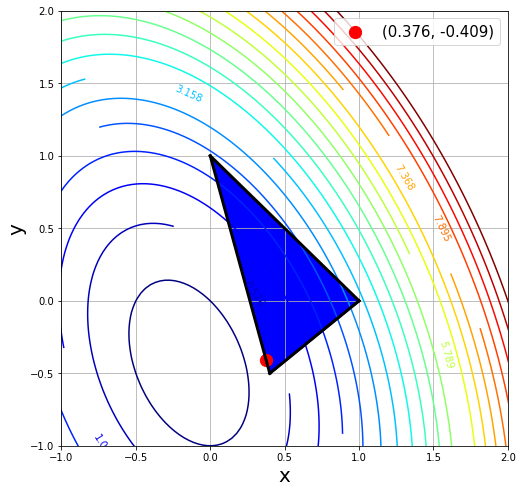

In [71]:
plt.figure(figsize=(8,8))
dom_x = np.linspace(-8, 8, 500)
dom_y = np.linspace(-8, 8, 500)
x_, y_ = np.meshgrid(dom_x, dom_y)
Z = 2*(x_)**2 + (y_)**2 + x_*y_ + x_ + y_
V = np.linspace(0, 10, 20)
cs = plt.contour(x_,y_,Z,V,cmap='jet')
plt.xlabel(u'x', fontsize=20)
plt.ylabel(u'y', fontsize=20)
plt.plot([0, 1], [1, 0], color='black', linewidth=3)
plt.plot([0, 0.4], [1, -0.5], color='black', linewidth=3)
plt.plot([0.4, 1], [-0.5, 0], color='black', linewidth=3)
plt.fill_between(np.linspace(0, 0.4, 100), 1 - np.linspace(0, 0.4, 100), 1 - (15/4)*np.linspace(0, 0.4, 100), color='blue')
plt.fill_between(np.linspace(0.4, 1, 100), y2=-5/6 + (5/6)*np.linspace(0.4, 1, 100), y1=1 - np.linspace(0.4, 1, 100), color='blue')
plt.clabel(cs)
plt.scatter(0.376, -0.409, color='red', s=150, label=u'(0.376, -0.409)')
plt.legend(fontsize=15)
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.grid()

${\bf \text{Пример (Проекция на шар):}}$

$\left\{\begin{array} { l } \frac{1}{2} \cdot \Vert x - x_{0} \Vert_{2}^2 \to \min\limits_{x} \\ \Vert x \Vert_{2}^2 \le 1\end{array} \right.$

$L = \frac{1}{2} \cdot (x^T x - 2 x_{0}^T x + x_{0}^{T} x_{0}) + \lambda \cdot (x^T x - 1)$

$\nabla_{x} L = x - x_{0} + \lambda \cdot x = 0 \Rightarrow x^{\ast} = \frac{x_{0}}{1 + \lambda}$

Подставим $x^{\ast}$ в условие дополняющей нежёсткости:

$\lambda \cdot \left( \frac{x_{0}^T x_{0}}{(1 + \lambda)^2} - 1 \right) = 0$

Получаем:

$\lambda^{\ast} = 0 $ (в случае, если точка лежит внутри шара), либо $\lambda^{\ast} = \sqrt{x_{0}^T x_{0}} - 1$,  $\left(-\sqrt{x_{0}^T x_{0}} - 1 \  \text{исключаем, потому что} \  \lambda^{\ast} \ge 0 \right)$

В итоге: $x^{\ast} = \frac{x_{0}}{1 + \sqrt{x_{0}^T x_{0}} - 1} = \frac{x_{0}}{\Vert x_{0} \Vert}$

---

$q(\lambda, \mu) = \underset{x}{inf} L(x, \lambda, \mu)$ - двойственная функция

Свойства:

1) $q(\lambda, \mu) \le f_{0}(x), \ \forall x, \lambda, \mu$

2) $q(\lambda^{\ast}, \mu^{\ast}) = f_{0}(x^{\ast})$ Если выполнено условие Слейтера

${\bf \text{Условие Слейтера:}}$

<ul>
<li>Задача является выпуклой (то есть: $f(x), \ g_{i}(x)$ - выпуклые функции, а $h_{j}(x)$ - афинные функции)</li>
<li>Существует хотя бы одна внутренняя допустимая точка (то есть: $\exists x_{0}: \ g_{i}(x_{0}) < 0$ для неафинных $g_{i}(x)$ )</li>
</ul>

---

${\bf \text{Пример:}}$

$\left\{\begin{array} { l } \frac{1}{2} \cdot \Vert x \Vert_{2}^2 \to \min\limits_{x} \\  Ax = b \end{array} \right.$

$L = \frac{1}{2} x^T x + \lambda^T (Ax - b)$

ККТ условия:

$\left \{ \begin{array}{l} \nabla_{x} L = x + A^T \lambda = 0 \\ \lambda^T (Ax - b) = 0   \end{array}\right . \Rightarrow \boxed{x^{\ast} = -A^T \lambda}$

Составим двойственную функцию: 

$q(\lambda) = \underset{x}{inf} L = \frac{1}{2} \lambda^T A A^T \lambda + \lambda^T (-AA^T \lambda - b) = -\frac{1}{2}\lambda^T A A^T \lambda -b^T \lambda \to \max\limits_{\lambda}$

$\nabla_{\lambda} q = -AA^T \lambda - b = 0 \Rightarrow \boxed{\lambda^{\ast} = -(AA^T)^{-1}b}$

Отсюда получаем:

$\boxed{x^{\ast} = A^T(AA^T)^{-1}b}$

Поскольку задача выпуклая, то должно быть выполнено условие сильной двойственности: $q(\lambda^{\ast}) = f(x^{\ast})$ (Проверьте!)

(Замечание:) Лямбду можно было найти и проще - подставить $x^{\ast}$ в ограничение:

$-AA^T \lambda = b \Rightarrow \lambda^{\ast} = - (AA^T)^{-1}b$

${\bf \text{Пример (Расстояние от точки до гиперплоскости):}}$

$\left\{\begin{array} { l } \frac{1}{2} \cdot \Vert x - x_{0} \Vert_{2}^2 \to \min\limits_{x} \\ w^T x = b   \end{array} \right.$

$L = \frac{1}{2}(x^T x - 2x_{0} x + x_{0}^T x_{0}) + \mu \cdot (w^Tx - b)$

$\nabla_{x} L = x - x_{0} + \mu \cdot w = 0 \Rightarrow \boxed{x^{\ast} = x_{0} - \mu \cdot w}$

Составим двойственную задачу:

$q(\mu) = \underset{x}{inf} L = \frac{1}{2} ((x_{0}^T - \mu \cdot w^T)(x_{0} - \mu \cdot w) - 2 x_{0}^T (x_{0} - \mu \cdot w) + x_{0}^T x_{0}) = -\frac{1}{2}w^T w \cdot \mu^2 + \mu \cdot (w^Tx_{0} - b) \to \max\limits_{\mu}$

$q'_{\mu} = -w^Tw \cdot \mu + w^T x_{0} - b = 0 \Rightarrow \boxed{\mu^{\ast} = \frac{w^T x_{0} - b}{w^Tw}   }$

Итак:

$\boxed{x^{\ast} = x_{0} - \frac{w^T x_{0} - b}{w^Tw}  \cdot w   }$ - проекция

$\boxed{ \Vert x^{\ast} - x_{0} \Vert_{2} = \frac{|w^Tx_{0} - b|}{\Vert w \Vert_{2}^2}}$ - само расстояние

# SVM

Реализация SVM для случая линейно-разделимой выборки (методом GD)

In [48]:
X = np.random.multivariate_normal(mean=[4, 5], cov=np.diag([5, 7]), size=200)
y = np.array([1]*len(X)).tolist()
X = np.vstack((X, np.random.multivariate_normal(mean=[15, 15], cov=np.diag([2, 3]), size=200)))
y = np.array(y + [0]*int(len(X)/2))

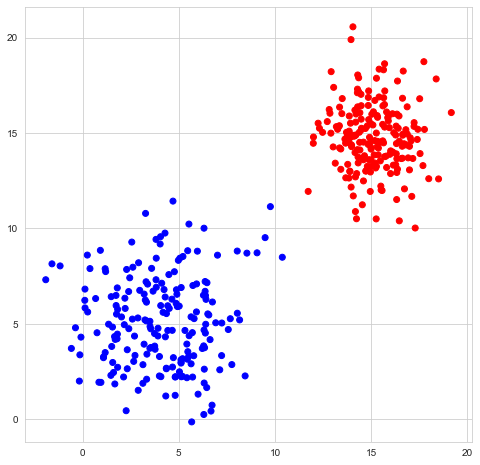

In [49]:
plt.scatter(X[:, 0], X[:, 1], c=np.array(['red', 'blue'])[y]);

In [53]:
class SVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.hist_params = []

    def fit(self, X, y, save_params_by_iteration=True):
        n_samples, n_features = X.shape
        # Если метки таргета {0, 1}, то переводим их в {-1, 1}
        y_ = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in tqdm_notebook(range(self.n_iters)):
            for idx, x_i in enumerate(X):
                # Находится ли точка по правильную сторону от гиперплоскости
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]
            if save_params_by_iteration: 
                self.hist_params.append([self.w, self.b])

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

In [54]:
model = SVM(n_iters=3001, learning_rate=0.001)
model.fit(X, y)

Изобразим решающую полосу на различных итерациях

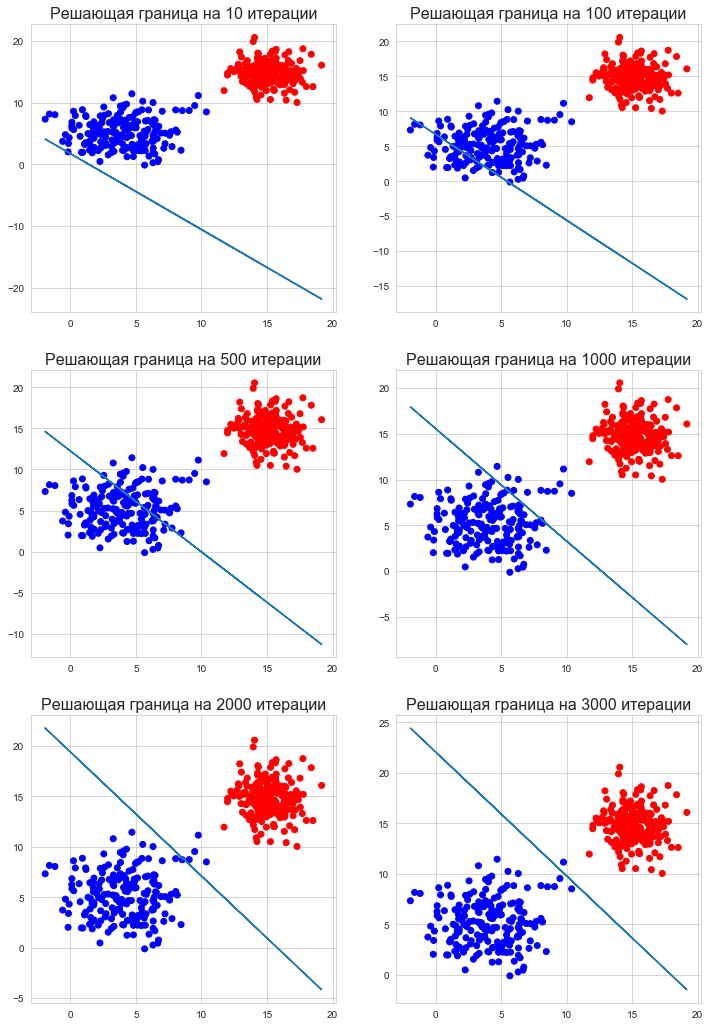

In [58]:
import itertools
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
hist_monents = [10, 100, 500, 1000, 2000, 3000]
for n, i in enumerate(itertools.product(range(3), range(2))):
    ax[i[0], i[1]].set_title('Решающая граница на {} итерации'.format(hist_monents[n]), 
                             fontsize=16);
    (w_0, w_1), b = model.hist_params[hist_monents[n]]
    ax[i[0], i[1]].scatter(X[:, 0], X[:, 1], c=np.array(['red', 'blue'])[y]);
    ax[i[0], i[1]].plot(X[:, 0], -(w_0/w_1)*X[:, 0] + b/model.w[1]);

Реализация с помощью пакета CVXOPT

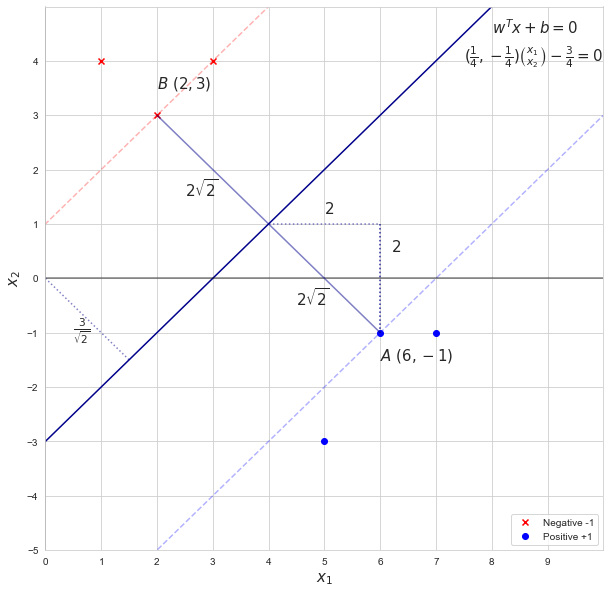

In [237]:
#Data set
x_neg = np.array([[3,4],[1,4],[2,3]])
y_neg = np.array([-1,-1,-1])
x_pos = np.array([[6,-1],[7,-1],[5,-3]])
y_pos = np.array([1,1,1])
x1 = np.linspace(-10,10)
x = np.vstack((np.linspace(-10,10),np.linspace(-10,10)))

#Data for the next section
X = np.vstack((x_pos, x_neg))
y = np.concatenate((y_pos,y_neg))

#Parameters guessed by inspection
w = np.array([1,-1]).reshape(-1,1)
b = -3

#Plot
fig = plt.figure(figsize = (10,10))
plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')
plt.plot(x1, x1  - 3, color = 'darkblue')
plt.plot(x1, x1  - 7, linestyle = '--', alpha = .3, color = 'b')
plt.plot(x1, x1  + 1, linestyle = '--', alpha = .3, color = 'r')
plt.xlim(0,10)
plt.ylim(-5,5)
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(-5, 5, step=1))

#Lines
plt.axvline(0, color = 'black', alpha = .5)
plt.axhline(0,color = 'black', alpha = .5)
plt.plot([2,6],[3,-1], linestyle = '-', color = 'darkblue', alpha = .5 )
plt.plot([4,6],[1,1],[6,6],[1,-1], linestyle = ':', color = 'darkblue', alpha = .5 )
plt.plot([0,1.5],[0,-1.5],[6,6],[1,-1], linestyle = ':', color = 'darkblue', alpha = .5 )

#Annotations
plt.annotate(s = '$A \ (6,-1)$', xy = (5,-1), xytext = (6,-1.5), size=15)
plt.annotate(s = '$B \ (2,3)$', xy = (2,3), xytext = (2,3.5), size=15)#, arrowprops = {'width':.2, 'headwidth':8})
plt.annotate(s = '$2$', xy = (5,1.2), xytext = (5,1.2), size=15)
plt.annotate(s = '$2$', xy = (6.2,.5), xytext = (6.2,.5), size=15)
plt.annotate(s = '$2\sqrt{2}$', xy = (4.5,-.5), xytext = (4.5,-.5), size=15)
plt.annotate(s = '$2\sqrt{2}$', xy = (2.5,1.5), xytext = (2.5,1.5), size=15)
plt.annotate(s = '$w^Tx + b = 0$', xy = (8,4.5), xytext = (8,4.5), size=15)
plt.annotate(s = '$(\\frac{1}{4},-\\frac{1}{4}) \\binom{x_1}{x_2}- \\frac{3}{4} = 0$', 
             xy = (7.5,4), xytext = (7.5,4), size=15)
plt.annotate(s = '$\\frac{3}{\sqrt{2}}$', xy = (.5,-1), xytext = (.5,-1), size=15)

#Labels and show
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.legend(loc = 'lower right')
plt.show()

In [242]:
m, n = X.shape
y = y.reshape(-1,1) * 1.
X_dash = y * X
H = np.dot(X_dash , X_dash.T) * 1.

P = cvxopt.matrix(H)
q = cvxopt.matrix(-np.ones((m, 1)))
G = cvxopt.matrix(-np.eye(m))
h = cvxopt.matrix(np.zeros(m))
A = cvxopt.matrix(y.reshape(1, -1))
b = cvxopt.matrix(np.zeros(1))
# Находим оптимум
sol = cvxopt.solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

In [245]:
# Находим вектор параметров
w = ((y*alphas).T.dot(X)).reshape(-1,1)
# Обозначаем опорные объекты
S = (alphas > 1e-10).flatten()
# Считаем смещение
b = y[S] - np.dot(X[S], w)

print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [0.0625     0.06249356]
w =  [ 0.24999356 -0.25000644]
b =  [-0.74996781]


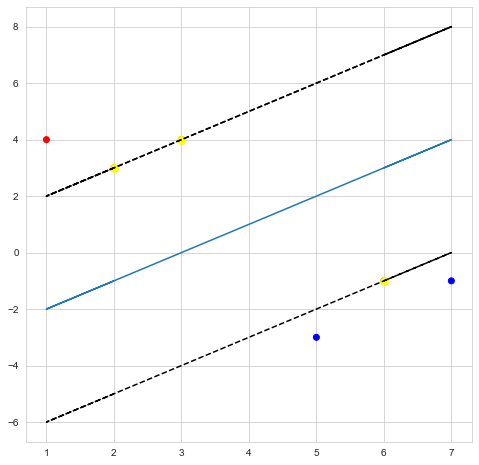

In [246]:
plt.scatter(X[:, 0], X[:, 1], c=np.array(['red', 'blue'])[(y.ravel() > 0).astype(int)]);
plt.scatter(X[S, 0], X[S, 1], color='yellow', s=60)
# Разделяющая граница
plt.plot(X[:, 0], -(w[0]/w[1])*X[:, 0] - b[0]/w[1]);
# Опорные объекты
for i in range(len(X[S])):
    plt.plot(X[:, 0], -(w[0]/w[1])*X[:, 0] + (X[S, 1][i] + (w[0]/w[1])*X[S, 0][i])[0], 
             color='black', linestyle='--');

Проделаем то же самое на большем наборе

In [247]:
X = np.random.multivariate_normal(mean=[4, 5], cov=np.diag([5, 7]), size=200)
y = np.array([1]*len(X)).tolist()
X = np.vstack((X, np.random.multivariate_normal(mean=[15, 15], cov=np.diag([2, 3]), size=200)))
y = np.array(y + [0]*int(len(X)/2))
y = 2*y - 1

In [248]:
m, n = X.shape
y = y.reshape(-1,1) * 1.
X_dash = y * X
H = np.dot(X_dash , X_dash.T) * 1.

P = cvxopt.matrix(H)
q = cvxopt.matrix(-np.ones((m, 1)))
G = cvxopt.matrix(-np.eye(m))
h = cvxopt.matrix(np.zeros(m))
A = cvxopt.matrix(y.reshape(1, -1))
b = cvxopt.matrix(np.zeros(1))
# Находим оптимум
sol = cvxopt.solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

In [249]:
# Находим вектор параметров
w = ((y*alphas).T.dot(X)).reshape(-1,1)
# Обозначаем опорные объекты
S = (alphas > 1e-10).flatten()
# Считаем смещение
b = y[S] - np.dot(X[S], w)

print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [0.25139274 0.25139274]
w =  [-0.66420076 -0.24823944]
b =  [10.09438226]


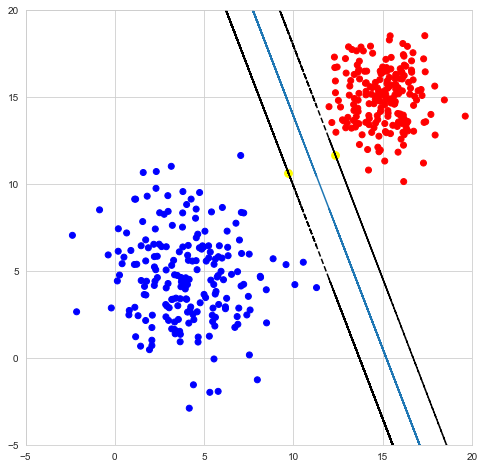

In [251]:
plt.scatter(X[:, 0], X[:, 1], c=np.array(['red', 'blue'])[(y.ravel() > 0).astype(int)]);
plt.scatter(X[S, 0], X[S, 1], color='yellow', s=60)
# Разделяющая граница
plt.plot(X[:, 0], -(w[0]/w[1])*X[:, 0] - b[0]/w[1]);
# Опорные объекты
for i in range(len(X[S])):
    plt.plot(X[:, 0], -(w[0]/w[1])*X[:, 0] + (X[S, 1][i] + (w[0]/w[1])*X[S, 0][i])[0], 
             color='black', linestyle='--');
plt.xlim(-5, 20);
plt.ylim(-5, 20);

Для случая линейно неразделимой выборки

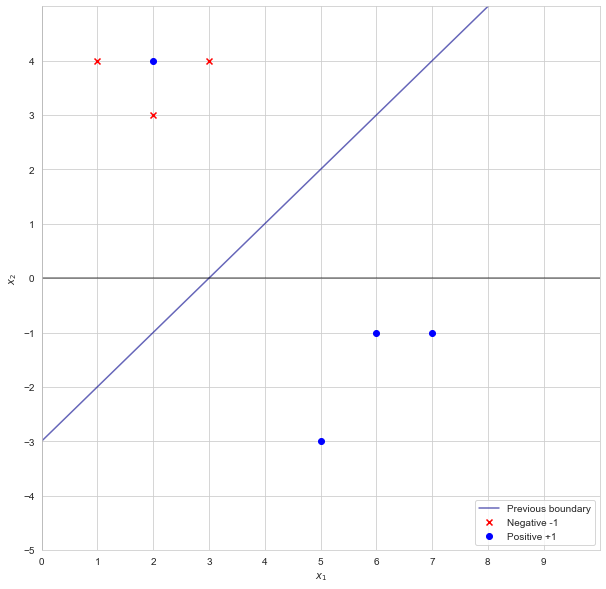

In [3]:
x_neg = np.array([[3,4],[1,4],[2,3]])
y_neg = np.array([-1,-1,-1])
x_pos = np.array([[6,-1],[7,-1],[5,-3],[2,4]])
y_pos = np.array([1,1,1,1])
x1 = np.linspace(-10,10)
x = np.vstack((np.linspace(-10,10),np.linspace(-10,10)))


fig = plt.figure(figsize = (10,10))
plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')
plt.plot(x1, x1  - 3, color = 'darkblue', alpha = .6, label = 'Previous boundary')
plt.xlim(0,10)
plt.ylim(-5,5)
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(-5, 5, step=1))

#Lines
plt.axvline(0, color = 'black', alpha = .5)
plt.axhline(0,color = 'black', alpha = .5)


plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.legend(loc = 'lower right')
plt.show()

#New dataset (for later)
X = np.array([[3,4],[1,4],[2,3],[6,-1],[7,-1],[5,-3],[2,4]] )
y = np.array([-1,-1, -1, 1, 1 , 1, 1 ]).reshape(-1, 1)

${\bf Алгоритм:}$

$a(x) = sign \left(<w, x> + b \right), \ $ $w = \sum\limits_{i=1}^n \lambda_{i}y_{i}x_{i}, 
\ $ $b = median \{ y_{i} - <w, x_{i}> | i: \lambda_{i} \not = 0  \}$

Двойственная задача:


$\left\{ \begin{array}{rcl}
q(\lambda) = -\frac{1}{2}\sum\limits_{i=1}^n \sum\limits_{j=1}^n \lambda_{i}\lambda_{j}y_{i}y_{j}<x_{i}, x_{j}> + \sum\limits_{i=1}^n \lambda_{i} \to \max\limits_{\lambda}\\
\sum\limits_{i=1}^n y_{i}\lambda_{i} = 0\\
0 \le \lambda_{i} \le C
\end{array} \right.$\\

$H = \left( y_{i}y_{j}<x_{i}, x_{j}> \right)_{i,j=1}^n$

В терминах cvxopt:

$\left\{ \begin{array}{rcl}
q(\lambda) = \frac{1}{2}\lambda^T H \lambda - \vec{1}^T \lambda \to \min\limits_{\lambda}\\
y^T \lambda = 0\\
-diag(\vec{1})\lambda \le \vec{0}\\
diag(\vec{1})\lambda \le C \cdot \vec{1}\\
\end{array} \right. \Rightarrow      
\left\{ 
\begin{array}{rcl}
q(\lambda) = \frac{1}{2}\lambda^T P \lambda - q^T \lambda \to \min\limits_{\lambda}\\
A \lambda = b\\
G\lambda \le h
\end{array} 
\right.
$

$P = H = \underset{n \times n}{\begin{bmatrix}
y_{1}y_{1}<x_{1}, x_{1}> & \dots & y_{1}y_{n}<x_{1}, x_{n}>\\
\vdots & \ddots & \vdots\\
y_{n}y_{1}<x_{n}, x_{1}> & \dots & y_{n}y_{n}<x_{n}, x_{n}>
\end{bmatrix}}, \ q = \underset{n \times 1}{\begin{bmatrix} 
-1\\
\vdots\\
-1
\end{bmatrix}}, \ A = \underset{1 \times n}{\begin{bmatrix} 
y_{1} & \dots & y_{n}\\
\end{bmatrix}}, \ b = \underset{1 \times 1}{\begin{bmatrix} 
0
\end{bmatrix}}, \\ G = \underset{(2n) \times n}{\begin{bmatrix} 
-1 & 0 & \dots & 0 & 0\\
0 & -1 & \dots & 0 & 0\\
\vdots & \vdots & \ddots & \vdots & \vdots\\
0 & 0 & \dots & -1 & 0\\
0 & 0 & \dots & 0 & -1\\
1 & 0 & \dots & 0 & 0\\
0 & 1 & \dots & 0 & 0\\
\vdots & \vdots & \ddots & \vdots & \vdots\\
0 & 0 & \dots & 1 & 0\\
0 & 0 & \dots & 0 & 1\\
\end{bmatrix}}, \ h = \underset{(2n)\times1}{\begin{bmatrix}
0\\
\vdots\\
0\\
C\\
\vdots\\
C
\end{bmatrix}}$

In [4]:
C = 1
P = cvxopt.matrix((X*y.reshape(-1, 1)).dot((X*y.reshape(-1, 1)).T), tc='d')
q = cvxopt.matrix(-1*np.ones(X.shape[0]).reshape(-1, 1))
A = cvxopt.matrix(y.reshape(1, -1), tc='d')
b = cvxopt.matrix([0], tc='d')
G = cvxopt.matrix(np.vstack((
    -1*np.eye(X.shape[0]), 
    np.eye(X.shape[0])
)), tc='d')
h = cvxopt.matrix(np.vstack((
    0*np.ones(X.shape[0]).reshape(-1, 1),
    C*np.ones(X.shape[0]).reshape(-1, 1)
)), tc='d')

In [5]:
sol = cvxopt.solvers.qp(P, q, G, h, A, b)
lambdas = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -3.2371e+00 -1.3861e+01  5e+01  2e+00  4e-15
 1: -2.1148e+00 -7.8018e+00  6e+00  4e-16  3e-15
 2: -2.2266e+00 -2.5428e+00  3e-01  1e-16  4e-15
 3: -2.3081e+00 -2.3587e+00  5e-02  1e-16  4e-15
 4: -2.3124e+00 -2.3132e+00  8e-04  3e-16  4e-15
 5: -2.3125e+00 -2.3125e+00  8e-06  1e-16  2e-15
 6: -2.3125e+00 -2.3125e+00  8e-08  2e-16  3e-15
Optimal solution found.


In [6]:
# Находим вектор параметров
w = ((y*lambdas).T.dot(X)).reshape(-1,1)
# Обозначаем опорные объекты
S = (lambdas > 1e-7).flatten()
# Считаем смещение
b = y[S] - np.dot(X[S], w)

print('Alphas = ',lambdas[lambdas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [0.49999998 0.68750001 0.18749997 1.        ]
w =  [ 0.24999999 -0.25000001]
b =  [-0.74999991]


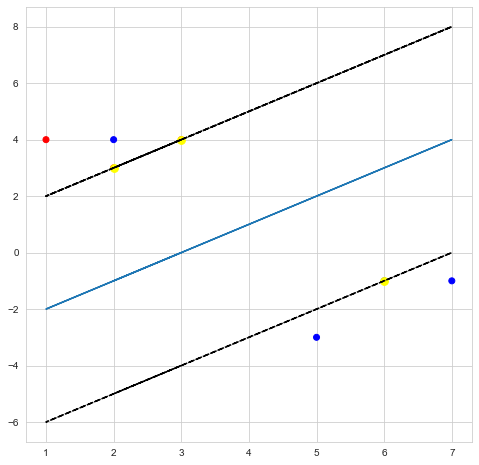

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=np.array(['red', 'blue'])[(y.ravel() > 0).astype(int)]);
plt.scatter(X[S, 0][:-1], X[S, 1][:-1], color='yellow', s=60)
# Разделяющая граница
plt.plot(X[:, 0], -(w[0]/w[1])*X[:, 0] - b[0]/w[1]);
# Опорные объекты
for i in range(len(X[S])-1):
    plt.plot(X[:, 0], -(w[0]/w[1])*X[:, 0] + (X[S, 1][i] + (w[0]/w[1])*X[S, 0][i])[0], 
             color='black', linestyle='--');
# plt.xlim(-5, 20);
# plt.ylim(-5, 20);

Можно решать и прямую задачу:


$
\left\{ \begin{array}{rcl}
&\frac{1}{2}\| w \|^2 + C \cdot \sum\limits_{i=1}^n \xi_{i}& \to \min\limits_{w, b, \xi_{i}}\\
&y_{i} \cdot \left( \langle w, x_{i} \rangle + b \right) \ge 1 - \xi_{i}&, \ i=1, 2, \dots, n\\
&\xi_{i} \ge 0&, \ i=1, 2, \dots, n 
\end{array} \right. \Rightarrow 
$
$
\left\{ \begin{array}{rcl}
\frac{1}{2}x^T P x + q^T x \to \min\limits_{x}\\
A x = b\\
Gx \le h
\end{array} \right.
$


$
x = (w_{1}, w_{2}, \dots, w_{d}, b, \xi_{1}, \xi_{2}, \dots, \xi_{n}), \ x \in \mathbb{R}^{d + 1 + n}
$

$
{\bf P} = \left[\begin{array}{ccccc|ccc}
1 & 0 & 0 & \dots & 0 & \dots & 0\\
0 & 1 & 0 & \dots & 0 & \dots & 0\\
0 & 0 & 1 & \dots & 0 & \dots & 0\\
\vdots & \vdots & \vdots & \ddots & \vdots & \ddots & \vdots\\
0 & 0 & 0 & \dots & 1 & \dots & 0\\\hline
\vdots & \vdots & \vdots & \ddots & \vdots & \ddots & \vdots\\
0 & 0 & 0 & \dots & 0 & \dots & 0\\
\end{array}\right] = 
\left[\begin{array}{@{}c|c@{}}
    I_{d \times d} & \mathbb{0}_{d \times (n+1)} \\\hline
    \mathbb{0}_{(n+1) \times d} & \mathbb{0}_{(n+1) \times (n+1)}
  \end{array}\right]
$


$
C \cdot \sum\limits_{i=1}^n \xi_{i} = C \cdot \xi_{1} + C \cdot \xi_{2} + \dots + C \cdot \xi_{n} = q^T \cdot x \Rightarrow
$

$
{\bf q} = \begin{bmatrix}
0 \\
0 \\
\vdots \\
0 \\
0 \\
C \\
C \\
\vdots \\
C
\end{bmatrix} = \begin{bmatrix} 
\mathbb{0}_{(d+1) \times 1}\\
C \cdot \mathbb{1}_{n \times 1}
\end{bmatrix}
$

$
{\bf A} = \mathbb{0}_{(d+n+1) \times (d+n+1)}, \ {\bf b} = \mathbb{0}_{(d+1+n) \times 1}
$

Для того, чтобы определить $G$ и $h$ нужно учесть 2 условия:

$
\xi_{i} \ge 0 \Rightarrow -\xi_{i} \le 0
$

и

$
y_{i} \cdot \left( \langle w, x_{i}  \rangle + b \right) \ge 1 - \xi_{i}  \Rightarrow
-y_{i} \cdot \left( \langle w, x_{i}  \rangle + b \right) - \xi_{i} \le -1 \Rightarrow
\left\{\begin{array}{rcl} 
- \langle w, x_{i} \rangle - b - \xi_{i} \le -1 , \ \text{если} \ y_{i} = +1 \\
\langle w, x_{i} \rangle + b - \xi_{i} \le -1 , \ \text{если} \ y_{i} = -1
\end{array} \right. \Rightarrow 
$

$
\underset{n \times 1}{\begin{bmatrix}
-w_{1} \cdot x_{1}^{(1)} - w_{2} \cdot x_{1}^{(2)} - \dots - w_{d} \cdot x_{1}^{(d)} - b - \xi_{1}\\
-w_{1} \cdot x_{2}^{(1)} - w_{2} \cdot x_{2}^{(2)} - \dots - w_{d} \cdot x_{2}^{(d)} - b - \xi_{2}\\
\vdots\\
-w_{1} \cdot x_{\#(y=+1)}^{(1)} - w_{2} \cdot x_{\#(y=+1)}^{(2)} - \dots - w_{d} \cdot x_{\#(y=+1)}^{(d)} - b - \xi_{\#(y=+1)}\\
w_{1} \cdot x_{\#(y=+1) + 1}^{(1)} + w_{2} \cdot x_{\#(y=+1) + 1}^{(2)} + \dots + w_{d} \cdot x_{\#(y=+1) + 1}^{(d)} + b - \xi_{\#(y=+1) + 1}\\
w_{1} \cdot x_{\#(y=+1)+2}^{(1)} + w_{2} \cdot x_{\#(y=+1)+2}^{(2)} + \dots + w_{d} \cdot x_{\#(y=+1)+2}^{(d)} + b - \xi_{\#(y=+1)+2}\\
\vdots\\
w_{1} \cdot x_{n}^{(1)} + w_{2} \cdot x_{n}^{(2)} + \dots + w_{d} \cdot x_{n}^{(d)} + b - \xi_{n}\\
\end{bmatrix}} \le 
\underset{n \times 1}{\begin{bmatrix} -1 \\ -1 \\ \vdots \\ -1  \end{bmatrix}} \Rightarrow
$

$
\underset{n\times(d+1+n)}{\left[\begin{array}{ccccc|c|ccccc|ccccc}
-x_{1}^{1} & -x_{1}^{(2)} & -x_{1}^{(3)} & \dots & -x_{1}^{(d)} & -1 & -1 & 0 & 0 & \dots & 0 & 0 & 0 & 0 & \dots & 0\\
-x_{2}^{1} & -x_{2}^{(2)} & -x_{2}^{(3)} & \dots & -x_{2}^{(d)} & -1 & 0 & -1 & 0 & \dots & 0 & 0 & 0 & 0 & \dots & 0\\
-x_{3}^{1} & -x_{3}^{(2)} & -x_{3}^{(3)} & \dots & -x_{3}^{(d)} & -1 & 0 & 0 & -1 & \dots & 0 & 0 & 0 & 0 & \dots & 0\\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
-x_{\#(y=1)}^{1} & -x_{\#(y=1)}^{(2)} & -x_{\#(y=1)}^{(3)} & \dots & -x_{\#(y=1)}^{(d)} & -1 & 0 & 0 & 0 & \dots & -1 & 0 & 0 & 0 & \dots & 0\\\hline
x_{\#(y=1)+1}^{1} & x_{\#(y=1)+1}^{(2)} & x_{\#(y=1)+1}^{(3)} & \dots & x_{\#(y=1)+1}^{(d)} & 1 & 0 & 0 & 0 & \dots & 0 & -1 & 0 & 0 & \dots & 0\\
x_{\#(y=1)+2}^{1} & x_{\#(y=1)+2}^{(2)} & x_{\#(y=1)+2}^{(3)} & \dots & x_{\#(y=1)+2}^{(d)} & 1 & 0 & 0 & 0 & \dots & 0 & 0 & -1 & 0 & \dots & 0\\
x_{\#(y=1)+3}^{1} & x_{\#(y=1)+3}^{(2)} & x_{\#(y=1)+3}^{(3)} & \dots & x_{\#(y=1)+3}^{(d)} & 1 & 0 & 0 & 0 & \dots & 0 & 0 & 0 & -1 & \dots & 0\\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
x_{n}^{1} & x_{n}^{(2)} & x_{n}^{(3)} & \dots & x_{n}^{(d)} & 1 & 0 & 0 & 0 & \dots & 0 & 0 & 0 & 0 & \dots & -1\\
\end{array}\right]} \cdot 
\underset{(d+1+n) \times 1}{\begin{bmatrix}
w_{1} \\
w_{2} \\
\vdots \\
w_{d} \\
b \\
\xi_{1} \\
\xi_{2} \\
\vdots \\
\xi_{n}
\end{bmatrix}} \le
\underset{n \times 1}{\begin{bmatrix} -1 \\ -1 \\ \vdots \\ -1  \end{bmatrix}} \Rightarrow
$

Добавляем первое условие и получаем:

$
\underset{2n\times(d+1+n)}{\left[\begin{array}{ccccc|c|ccccc|ccccc}
-x_{1}^{1} & -x_{1}^{(2)} & -x_{1}^{(3)} & \dots & -x_{1}^{(d)} & -1 & -1 & 0 & 0 & \dots & 0 & 0 & 0 & 0 & \dots & 0\\
-x_{2}^{1} & -x_{2}^{(2)} & -x_{2}^{(3)} & \dots & -x_{2}^{(d)} & -1 & 0 & -1 & 0 & \dots & 0 & 0 & 0 & 0 & \dots & 0\\
-x_{3}^{1} & -x_{3}^{(2)} & -x_{3}^{(3)} & \dots & -x_{3}^{(d)} & -1 & 0 & 0 & -1 & \dots & 0 & 0 & 0 & 0 & \dots & 0\\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
-x_{\#(y=1)}^{1} & -x_{\#(y=1)}^{(2)} & -x_{\#(y=1)}^{(3)} & \dots & -x_{\#(y=1)}^{(d)} & -1 & 0 & 0 & 0 & \dots & -1 & 0 & 0 & 0 & \dots & 0\\\hline
x_{\#(y=1)+1}^{1} & x_{\#(y=1)+1}^{(2)} & x_{\#(y=1)+1}^{(3)} & \dots & x_{\#(y=1)+1}^{(d)} & 1 & 0 & 0 & 0 & \dots & 0 & -1 & 0 & 0 & \dots & 0\\
x_{\#(y=1)+2}^{1} & x_{\#(y=1)+2}^{(2)} & x_{\#(y=1)+2}^{(3)} & \dots & x_{\#(y=1)+2}^{(d)} & 1 & 0 & 0 & 0 & \dots & 0 & 0 & -1 & 0 & \dots & 0\\
x_{\#(y=1)+3}^{1} & x_{\#(y=1)+3}^{(2)} & x_{\#(y=1)+3}^{(3)} & \dots & x_{\#(y=1)+3}^{(d)} & 1 & 0 & 0 & 0 & \dots & 0 & 0 & 0 & -1 & \dots & 0\\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
x_{n}^{1} & x_{n}^{(2)} & x_{n}^{(3)} & \dots & x_{n}^{(d)} & 1 & 0 & 0 & 0 & \dots & 0 & 0 & 0 & 0 & \dots & -1\\\hline
0 & 0 & 0 & \dots & \vdots & 0 & -1 & 0 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0\\
0 & 0 & 0 & \dots & \vdots & 0 & 0 & -1 & 0 & \dots & \dots & \dots & \dots & \dots & \dots & 0\\
0 & 0 & 0 & \dots & \vdots & 0 & 0 & 0 & -1 & \dots & \dots & \dots & \dots & \dots & \dots & 0\\
\vdots & \vdots & \vdots & \dots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
\vdots & \vdots & \vdots & \dots & \vdots & \vdots & \vdots & \vdots & \vdots & \dots & -1 & 0 & 0 & 0 & \dots & 0\\
\vdots & \vdots & \vdots & \dots & \vdots & \vdots & \vdots & \vdots & \vdots & \dots & 0 & -1 & 0 & 0 & \dots & 0\\
\vdots & \vdots & \vdots & \dots & \vdots & \vdots & \vdots & \vdots & \vdots & \dots & 0 & 0 & -1 & 0 & \dots & 0\\
\vdots & \vdots & \vdots & \dots & \vdots & \vdots & \vdots & \vdots & \vdots & \dots & 0 & 0 & 0 & -1 & \dots & 0\\
\vdots & \vdots & \vdots & \dots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
0 & 0 & 0 & \dots & 0 & 0 & 0 & 0 & 0 & \dots & 0 & 0 & 0 & 0 & \dots & -1\\
\end{array}\right]} \cdot 
\underset{(d+1+n) \times 1}{\begin{bmatrix}
w_{1} \\
w_{2} \\
\vdots \\
w_{d} \\
b \\
\xi_{1} \\
\xi_{2} \\
\vdots \\
\xi_{n}
\end{bmatrix}} \le
\underset{2n \times 1}{\begin{bmatrix} -1 \\ -1 \\ \vdots \\ -1 \\ 0 \\ 0 \\ \vdots \\ 0  \end{bmatrix}} \Rightarrow
$

$
{\bf G} = \left[\begin{array}{c|c|c}
-X_{y = 1} & -\mathbb{1}_{\#(y=1) \times 1} & I_{\#(y=1)} & \mathbb{0}_{\#(y=1) \times \#(y=-1)}\\
X_{y=-1} & \mathbb{1}_{\#(y=-1) \times 1} & \mathbb{0}_{\#(y=-1) \times \#(y=1)} & I_{\#(y=-1)}\\
\mathbb{0}_{n \times (d+1)} & - I_{n}
\end{array}\right], \ 
{\bf h} = \begin{bmatrix}
- \mathbb{1}_{n \times 1}\\
\mathbb{0}_{n \times 1}
\end{bmatrix}
$

In [39]:
C = 1
n, d = X.shape
n_y_pos = (y.ravel() == 1).sum()
n_y_neg = (y.ravel() == -1).sum()

X = X[np.argsort(y.ravel())[::-1]]
y = np.sort(y.ravel())[::-1].reshape(-1, 1)

P = cvxopt.matrix(
    2*np.vstack((
        
        np.hstack((
            np.eye(d),
            np.zeros((d, n+1))
        )),
        
        np.hstack((
            np.zeros((n+1, d)),
            np.zeros((n+1, n+1))
        ))
    ))
)
q = cvxopt.matrix(
    np.vstack((
        np.zeros((d+1, 1)),
        C * np.ones((n, 1))
    ))
)
# A = cvxopt.matrix(y.reshape(1, -1), tc='d')
# b = cvxopt.matrix([0], tc='d')
G = cvxopt.matrix(
    np.vstack((
        np.hstack((
            -X[y.ravel() == 1],
            -np.ones((n_y_pos, 1)),
            np.eye(n_y_pos),
            np.zeros((n_y_pos, n_y_neg))
        )),
        
        np.hstack((
            X[y.ravel() == -1],
            np.ones((n_y_neg, 1)),
            np.zeros((n_y_neg, n_y_pos)),
            np.eye(n_y_neg)
        )),
        
        np.hstack((
            np.zeros((n, d+1)),
            -np.eye(n)
        ))
    ))
    , 
    tc='d'
)
h = cvxopt.matrix(
    np.vstack((
        -np.ones((n, 1)),
        np.zeros((n, 1))
    ))
    , 
    tc='d'
)

In [41]:
# sol = cvxopt.solvers.qp(P=P, q=q, G=G, h=h)
# w_b_xi = np.array(sol['x'])